# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Цель и задачи проекта

Основная цель проекта - выяснить является ли количество детей, семейное положение клиента, его уровень доходов и цели получения кредитования на факт погашения кредита в срок.

Основными задачами во время работы проекта являются Задачами проекта являются:
1. Ознакомиться с данными и выявить потенциальные проблемы при работы с ними;
2. Определение и заполнение пропущенных значений;
3. Замена типа данных в столбцах, где они неверно определяются;
4. Выявление и обработка дубликатов;
5. Выделение групп данных и их категоризация;
6. Анализ влияния данных на возврат кредита.

Для анализа от предоставлена таблица с данными в формате csv, где в столбцы выделена основная информация по клиентам, которая может быть использована для построения модели кредитного скоринга.

Всего в таблице 12 столбцов:<br>
`children` — количество детей в семье<br>
`days_employed` — общий трудовой стаж в днях<br>
`dob_years` — возраст клиента в годах<br>
`education` — уровень образования клиента<br>
`education_id` — идентификатор уровня образования<br>
`family_status` — семейное положение<br>
`family_status_id` — идентификатор семейного положения<br>
`gender` — пол клиента<br>
`income_type` — тип занятости<br>
`debt` — имел ли задолженность по возврату кредитов<br>
`total_income` — ежемесячный доход<br>
`purpose` — цель получения кредита

## Выгрузка данных <a id="start"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pymystem3 import Mystem

In [2]:
data = pd.read_csv('credit_score_data.csv')
data.info() 
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**


Названия столбцов в таблице корректны: нет лишних пробелов, заглавных букв, все названия на английском языке.
В предоставленной базе данных обнаружены следующие недочеты: 
- пропуски меются в столбцах `days_employed` и `total_income`;
- В столбце `days_employed` имеются отрицательные значения, что не соответствует логике столбца;
- количество дней стажа может быть только целочисленным значением, значит необходимо изменить тип столбца `days_employed` на int64;
- в столбце `education` элементы прописаны разным регистром, необходимо привести их к единому виду;
- в столбце `gender` имеется странное значение `XNA`;
- в столбце `purpose` много близких по смыслу значений, необходимо выделить основные назначения и переименовать элементы столбца. 

## Предобработка данных <a id="preprocessing"></a>

In [3]:
data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

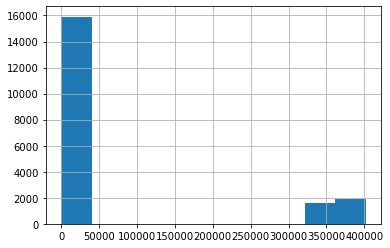

In [4]:
# Возьмём все отрицательные значения стажа по модулю. 
data['days_employed'] = abs(data['days_employed'])
data['days_employed'].hist()
plt.show()

Пропуски в столбце стажа устранены. 
Необходимо выяснить у кредитного отдела причины появления ошибок в данном столбце.
Отрицательные значения могут быть вызваны человеческим фактором или неверной формулой подсчета, зашитой в анкете клиента.
Тоже самое относится к стажу в сотни лет, возможно были проставлены лишние нули в числах.

In [5]:
(data['days_employed'].isnull()).equals(data['total_income'].isnull())

True

### Обработка пропусков <a id="null"></a>

In [6]:
# Заменяем пустые значения стажа медианным значением для каждого типа занятости
data['days_employed'] = data.groupby('income_type')['days_employed'].apply(lambda x: x.fillna(x.median())) 

In [7]:
# Заменяем пустые значения дохода медианным значением для каждого типа занятости
data['total_income'] = data.groupby('income_type')['total_income'].apply(lambda x: x.fillna(x.median())) 

In [8]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Причины наличия пропусков в этих двух столбцах не случайны: люди могут не работать и соответственно не получать доход. Это в первую очередь относится к клиентам определенного типа занятости: студенты, пенсионеры и т.п.

Пустые значения в столбцах заполнили медианными значения по соответствующим типам занятости.

### Замена типа данных <a id="type"></a>

In [9]:
# Заменим тип столбцов, в которых были пропуски на целочисленный.
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.dtypes

children             int64
days_employed        int32
dob_years            int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int32
purpose             object
dtype: object

In [10]:
total_income_median = data['total_income'].median()
'Медианный доход: {:.0f} рублей'.format(total_income_median)

'Медианный доход: 142594 рублей'

**Вывод**

Заменили типы данных в столбцах со стажем и доходом на целочисленные. Определили медианный доход клиентов - 142594 рубля.

### Обработка дубликатов <a id="duplicates"></a>

In [11]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

В результате проверки видим, что в столбце `education` имеются дубликаты, причина их появления - разные регистры значений.
Уберём дубликаты путём привидения всех значений стоблца к единому регистру - нижнему.

In [12]:
data.duplicated().sum()

54

In [13]:
data['education'] = data['education'].str.lower() #значения привели к единому регистру
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [14]:
data.duplicated().sum()

71

После приведения значений столбца `education` к общему регистру число дубликтов увеличилось.

In [15]:
data = data.drop_duplicates().reset_index(drop = True)
'Число дубликатов в таблице:', data.duplicated().sum()

('Число дубликатов в таблице:', 0)

**Вывод**

До того, как приступили к обработке дубликатов их число составляло 54. После приведения значений столбца `education`к единому регистру, число дубликатов увеличилось до 71. Все выявленные дубликаты были удалены.

### Лемматизация <a id="lemmas"></a>

In [16]:
# Проверяем какие значения имеются в столбце purpose
data['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Необходимо привести значения в столбце к одной из 4 групп.

In [17]:
m = Mystem()
def lemmatize(text):
      lemmas = m.lemmatize(text)
      text = " ".join(lemmas)
      return text
data['purpose'] = data['purpose'].apply(lemmatize)
data['purpose'].value_counts()


KeyboardInterrupt



**Вывод**

Используя библиотеку `pymystem3` выделили леммы в каждой строке столбца с `purpose`. Все представленные значения в столбце можно укрупнённо разделить на 4 группы: `недвижимость`, `автокредит`, `свадьба`, `образование`. Далее объединим их в одну из 4 групп, определенных ранее.

### Категоризация данных <a id="classification"></a>

In [ ]:
#Осуществим категоризацию данных
def purpose(text):
    words = ['недвижимость', 'автомобиль', 'свадьба', 'образование', 'жилье']
    for word in words:
        if word in text:
            return word
data['purpose'] = data['purpose'].apply(purpose)
data['purpose'].value_counts()

Если применить эту функцию, то значения в столбце заменяются на значения из списка `words`, однако остаётся проблема объединения значений `недвижимость` и `жилье` в общую группу `недвижимость` и замены леммы `автомобиль` на `автокредит`.
Попытка заменить значения вручную при помощи `.loc` не срабатывает: `.value_counts` возвращает значения до категоризации.

Для приведения значений к указанным группам заменим значения `жилье` и `автомобиль`

In [ ]:
data.loc[data['purpose'] == 'жилье', 'purpose'] = 'недвижимость'
data.loc[data['purpose'] == 'автомобиль', 'purpose'] = 'автокредит'
data['purpose'].unique()

**Вывод**

Все значения в столбце `purpose` приведены к одной из 4 групп: `недвижимость`, `автокредит`, `свадьба`, `образование`.

## Дополнительные вопросы исследования 

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

В столбце имеются недостоверные значения `-1`и `20`, возможно ошибка связана с человеческим фактором. Предполагаем, что для значения `-1` имелось в виду `1`.
Значение `20` можно оставить без изменений, т.к. количество строк с ним незначительное. Будем считать эти значение, как подтверждение наличия детей у заемщика. Возможная причина такого большого количества детей - лишний ноль при вводе информации.

In [ ]:
data['children'] = abs(data['children'])
data['children'].value_counts()

In [ ]:
def children_count(children):
    if children > 0:
        return 1
    else:
        return 0
data['children_count'] = data['children'].apply(children_count)

In [ ]:
pivot_children = data.pivot_table(index='children_count', columns='debt', values = 'gender', aggfunc='count')
pivot_children['ratio'] = pivot_children[1] / (pivot_children[0] + pivot_children[1]) 
pivot_children.round(3)

**Вывод**

По результатам анализа доля клиентов с детьми, у которых имеется просроченная задолженность составляет **9,2%**;
доля клиентов без детей с просроченной задолженностью - **7,5%**

- Есть ли зависимость между семейным положением и возвратом кредита в срок?


In [ ]:
pivot_family = data.pivot_table(index = ['family_status'], columns = 'debt', values = 'gender', aggfunc = 'count')
pivot_family['ratio'] = pivot_family[1] / (pivot_family[0] + pivot_family[1])
pivot_family.sort_values('ratio', ascending = False).round(3)

**Вывод**

Для клиентов, которые никогда не состояли в официальному браке процент просрочек выше. Возможно, это обусловлено некоторой безответственностью и меньшим уровнем финансовой дисциплиной у заемщиков, которые привыкли следить только за личным бюджетом.
Нахождение заемщика в гражданском браке не способствует лучшей платежеспособности заемщика, в отличие от зарегистрированного брака.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
data['total_income'].describe().round(2)

Для удобства выделим разделим доходы заемщиком на 4 группы по квантилям

In [ ]:
data['income_group'] = pd.qcut(data['total_income'],4)

In [ ]:
pivot_income = data.pivot_table(index = ['income_group'], columns = 'debt', values = 'gender', aggfunc = 'count')
pivot_income['ratio'] = pivot_income[1] / (pivot_income[0] + pivot_income[1])
pivot_income.round(3)

**Вывод**

Получившиеся вероятности задолженности групп заемщиков:

доход менее 107,6 тыс. руб. = 8%  
доход в диапазоне от 107,6 до 142,6 тыс. руб. = 8,8%  
доход в диапазоне от 142,6 до 195,8 тыс. руб. = 8,5%  
доход свыше 195,8 тыс.руб. = 7,1%  

Наилучшая платежеспособность у клиентов, которые получают свыше 195,8 т.р. Возможно это обусловлено тем, что такая группа заемщиков берёт больше кредитов на инвестиционные цели,которые приносят дополнительный доход, что способствует возвратам кредитов. Зачастую клиенты с высокими доходами имеют свой бизнес, что может послужить стимул в сохранении положительной кредитной истории.
Следом идут клиенты, входящие в группу с наименьшим  уровнем доходов: до 107,6 т.р., что кажется контринтуитивным, но может объяснятся тем, что клиенты берут небольшие суммы кредитов. 
Набольшая доля просроченной задолженности наблюдается у клиентов с доходом от 107,6 т.р. до 195,8 т.р.

- Как разные цели кредита влияют на его возврат в срок?

In [ ]:
pivot_purpose = data.pivot_table(index='purpose', columns ='debt', values = 'gender',aggfunc='count')
pivot_purpose['ratio'] = pivot_purpose[1] / (pivot_purpose[0] + pivot_purpose[1])
pivot_purpose.round(3)

**Вывод**

Вероятность задолженности для каждой цели получения кредита от большей к меньшей:

1. автомобиль - 9,4%
2. образование - 9,2%
3. свадьба - 8%
4. недвижимость - 7,2%
Лучшая платежеспособность наблюдается у клиентов, которые берут кредиты на цели связанные с приобретение недвижимости.
Причины этого могут быть следующие:
- более низкие ставки по ипотечным кредитам, по сравнению с потребительскими кредитами;
- обычно по таким кредитам приобретаемое имущество находится в залоге у банка и клиенты заинтересованы в соблюдении кредитной дисциплины, чтобы заложенное имущество не было изъято.
- в случае приобретения недвижимости в коммерческих целях (продажа, сдача в аренду), клиенты могут гасить кредиты частично или полностью за счёт денежных поступлений от этих операций.

Второй по уровню возвратов целью является свадьба, что может обусловлено тем, что в случае необходимости кредит могу погашать оба супруга, это также коррелирует с выводом, что у клиентов, находящихся в браке лучшая платежная дисциплина.

Высокая доля просрочек по кредитам на образование может объяснятся тем, что их в основном берут студенты, у которых может не быть стабильного заработка, доходы на стартовых позициях довольно скромные для содержания долга.

Наибольшая вероятность просрочек у автокредитов так же логична, зачастую именно по этим кредитам выявляется наибольшая доля мошенничества. Приобретенные за счет кредита автомобили могут быть повреждены, что является причиной для некоторых клиентов не осуществлять платежи по кредитам вовремя пока не будет получено страховое возмещение.


## Общий вывод <a id="conclusion"></a>

Лучший заемщик с точки зрения вероятности возврата кредита - клиент, который находится или находился в официально браке, у которого нет детей, доходы у которого выше 195,8 тыс.руб., целью получения кредита которого является приобретение недвижимости.

Данные исследования можно использовать в посторении скоринговой модели для оценки платежеспособности заемщика.